In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from torchnlp.datasets import penn_treebank_dataset
import torch
from torch.utils.data import DataLoader
from rsm_samplers import ptb_pred_sequence_collate
from ptb import lang_util
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.nn import CrossEntropyLoss, MSELoss
from importlib import reload 
from torch.utils.data import Sampler, BatchSampler
import rsm
from functools import reduce, partial
import matplotlib.pyplot as plt

In [2]:
reload(lang_util)
corpus = lang_util.Corpus('/Users/jgordon/nta/datasets/PTB')

print(corpus.read_out(corpus.train[:60]))

print(len(corpus.valid), len(corpus.test), len(corpus.train))

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos> mr. <unk> is chairman of <unk> n.v. the dutch publishing group <eos> rudolph <unk> N years old and former
73760 82430 929589


In [272]:
import rsm_samplers
import rsm
from ptb import lang_util
reload(rsm_samplers)
reload(rsm)
reload(lang_util)

VISUAL = False
DATA_KIND = 'smnist'  # 'ptb'

if VISUAL:
    MB = 3
    EPOCHS = 1
    BS = 1
else:
    BS = 128
    MB = 100
    EPOCHS = 10

if DATA_KIND == 'smnist':
    d_in = 28 ** 2
    d_out = d_in
elif DATA_KIND == 'ptb':
    VS = 10000
    d_in = d_out = 28

m=20
n=4
k=3
k_winner_cells=1
eps = [0.0, 0.0]
forget_mu = 0.0
N_LAYERS = 2
weight_sparsity = None
tp_boosting = True
feedback = True
decode_from_full_memory = True

model = rsm.RSMNet(n_layers=N_LAYERS,
                   m=m, 
                   n=n, 
                   d_in=d_in, 
                   d_out=d_out, 
                   embed_dim=d_in,
                   k=k, 
                   k_winner_cells=k_winner_cells, 
                   eps=eps, 
                   do_inhibition=False,
                   x_b_norm=True, 
                   boost_strat='col_boosting', 
                   forget_mu=forget_mu, 
                   decode_from_full_memory=decode_from_full_memory,
                   weight_sparsity=weight_sparsity,
                   feedback=feedback,
                   input_bias=True,
                   loss_layers='first',
                   tp_boosting=tp_boosting,
                   visual_debug=VISUAL
)

if DATA_KIND == "smnist":
    dataset = rsm_samplers.MNISTBufferedDataset("~/nta/datasets", download=True,
                                               transform=transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))
                                               ]),)
    sampler = rsm_samplers.MNISTSequenceSampler(dataset, sequences=[[0,1,2,3], [0,3,2,1]], 
                                                batch_size=BS,
                                                max_batches=MB,
                                                random_mnist_images=True)
    loader = DataLoader(dataset,
                 batch_sampler=sampler,
                 collate_fn=rsm_samplers.pred_sequence_collate)
    
elif DATA_KIND == "ptb":
    bwe = lang_util.BitwiseWordEmbedding()

    corpus = lang_util.Corpus('/Users/jgordon/nta/datasets/PTB')
    collate_fn = partial(rsm_samplers.ptb_pred_sequence_collate, vector_dict=bwe.embedding_dict)

    sampler = rsm_samplers.PTBSequenceSampler(corpus.train, batch_size=BS, max_batches=MB)
    loader = DataLoader(corpus.train,
                           batch_sampler=sampler,
                           collate_fn=collate_fn)

criterion = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

Created <RSMLayer m=20 n=4 k=3 d_in=784 eps=0.00 /> with 92164 trainable params
Created <RSMLayer m=20 n=4 k=3 d_in=80 eps=0.00 /> with 21060 trainable params
Created RSMNet with 2 layer(s)


Finished batch 0


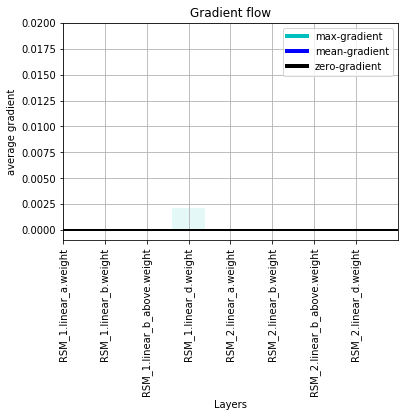

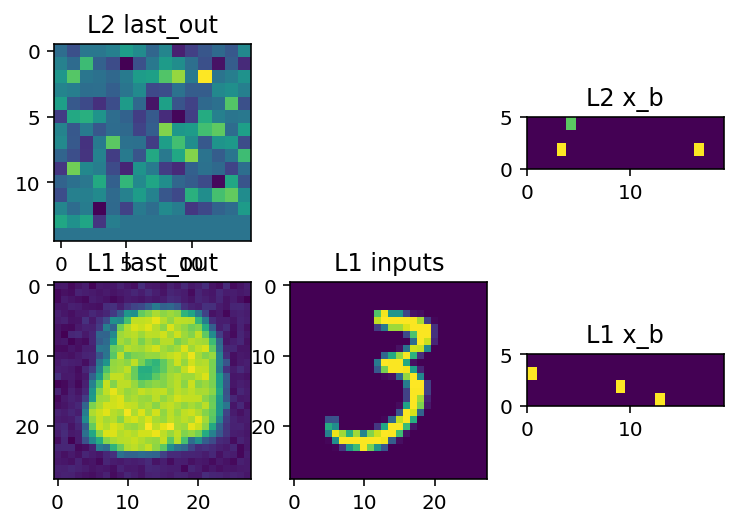

Finished batch 50


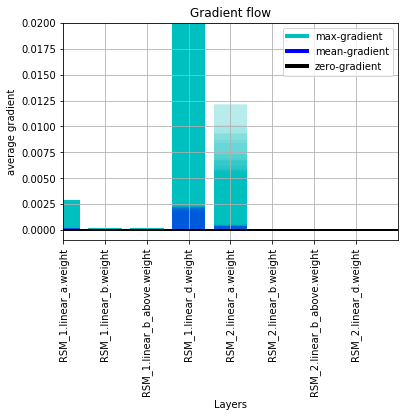

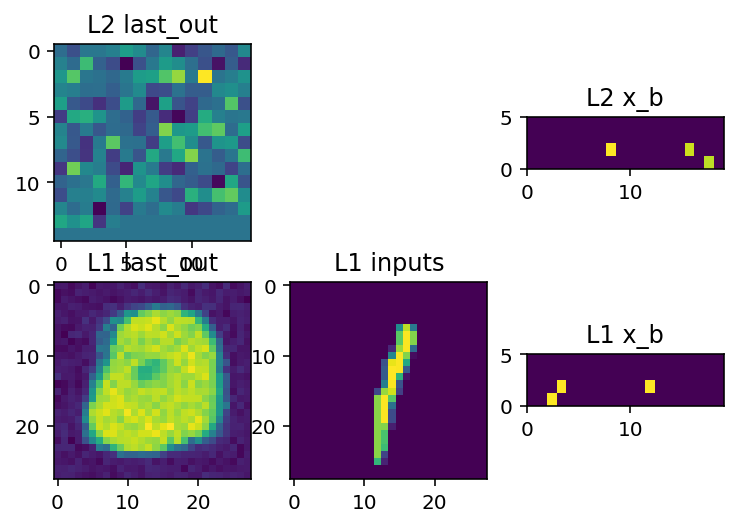

epoch 0 loss 93.06095707416534
Finished batch 0


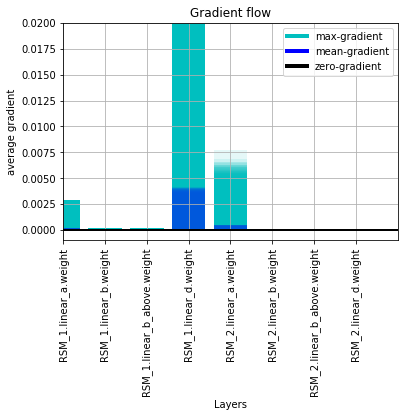

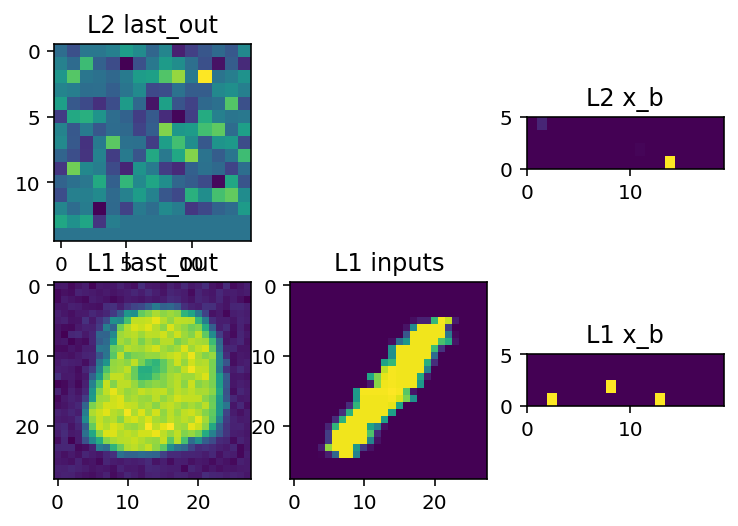

Finished batch 50


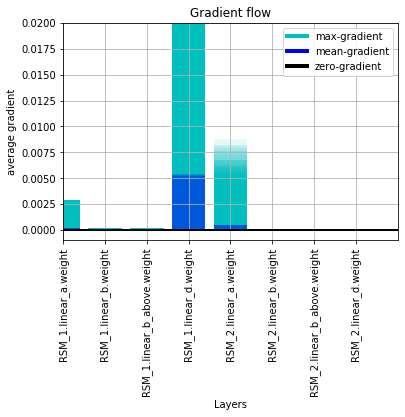

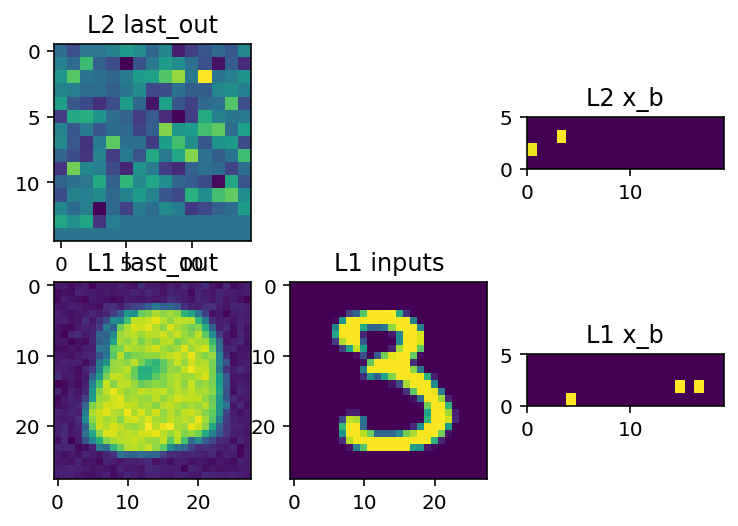

epoch 1 loss 74.6624465584755
Finished batch 0


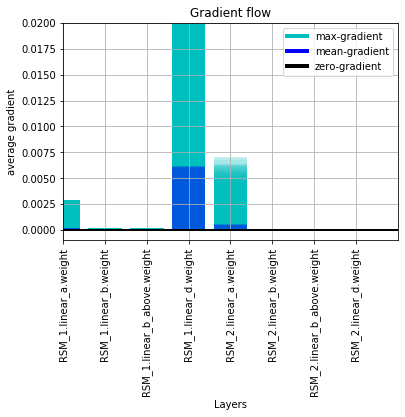

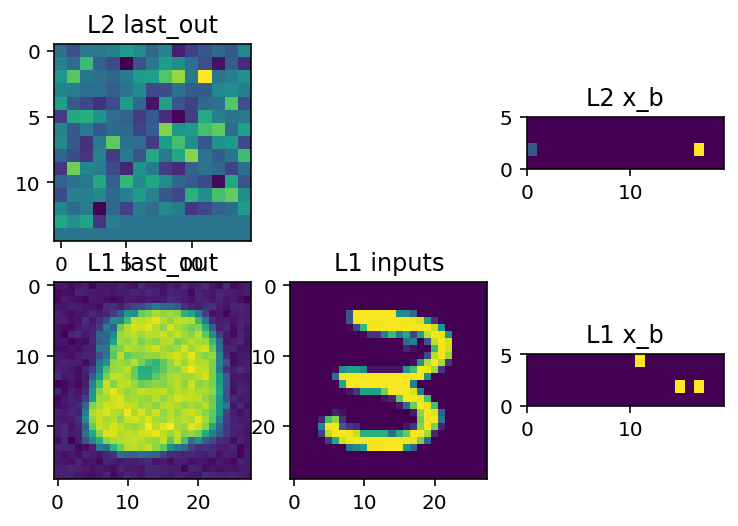

Finished batch 50


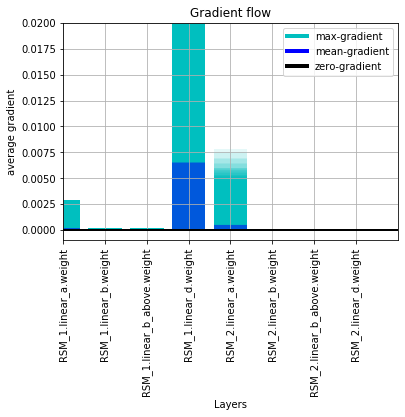

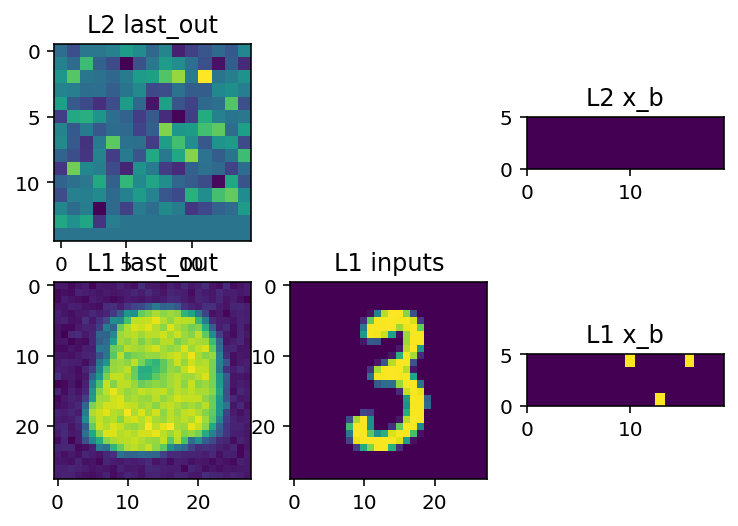

epoch 2 loss 66.64730340242386
Finished batch 0


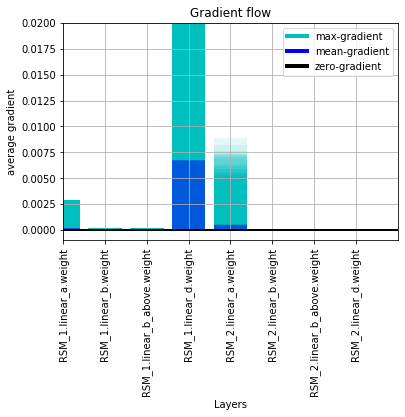

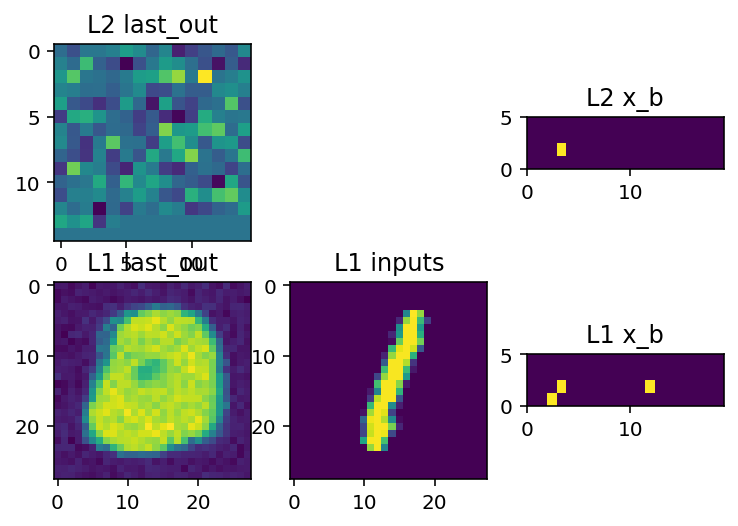

Finished batch 50


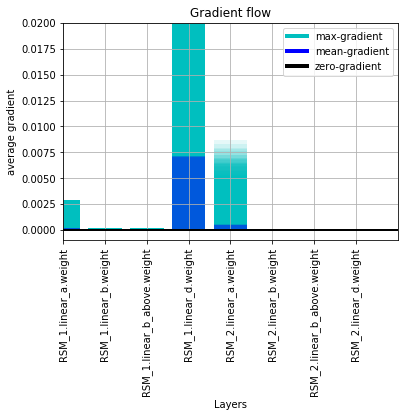

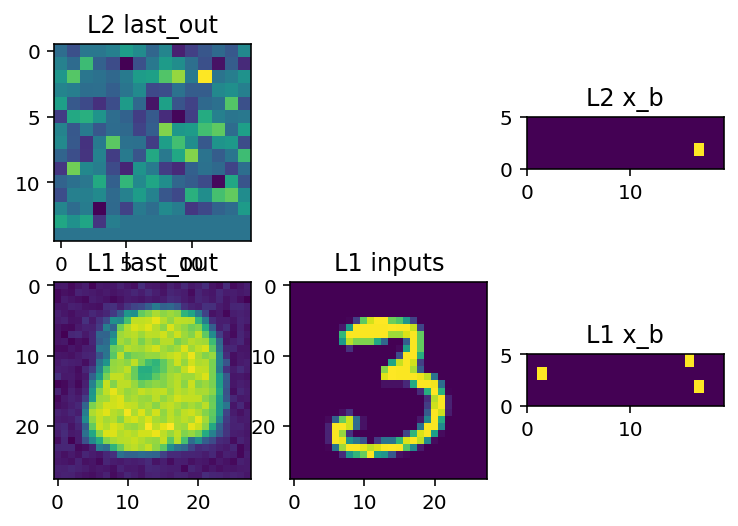

epoch 3 loss 61.42233633995056
Finished batch 0


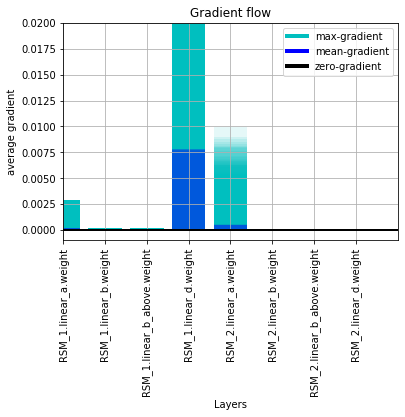

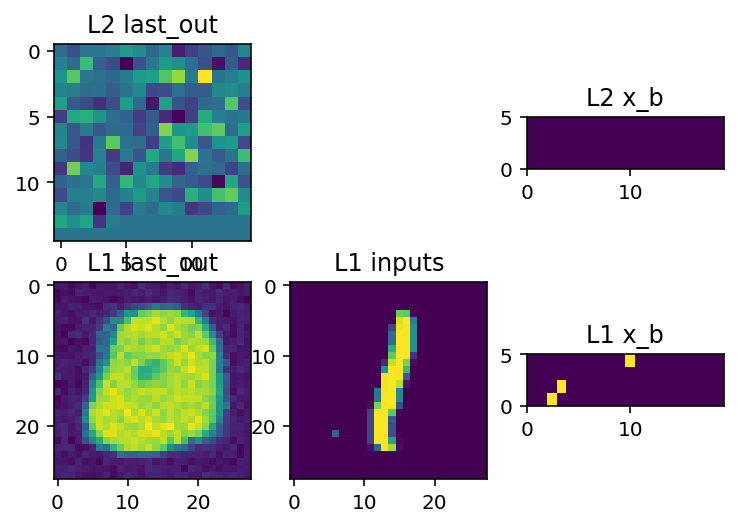

Finished batch 50


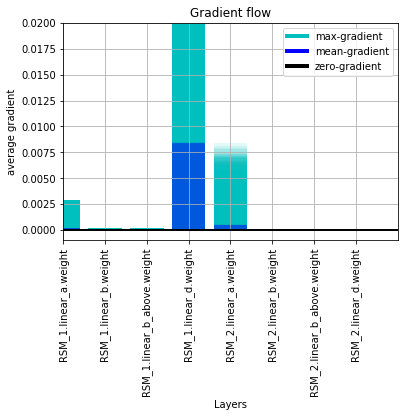

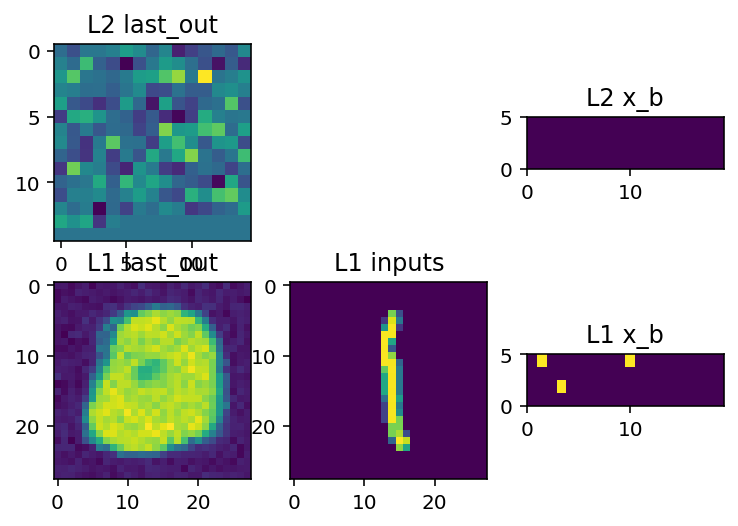

epoch 4 loss 55.87079358100891
Finished batch 0


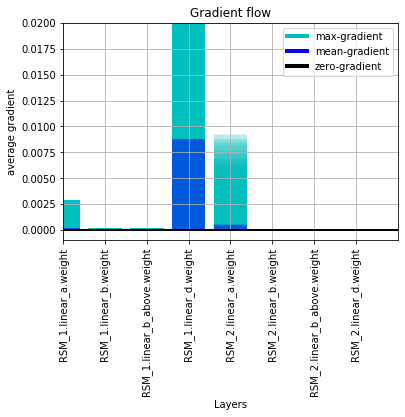

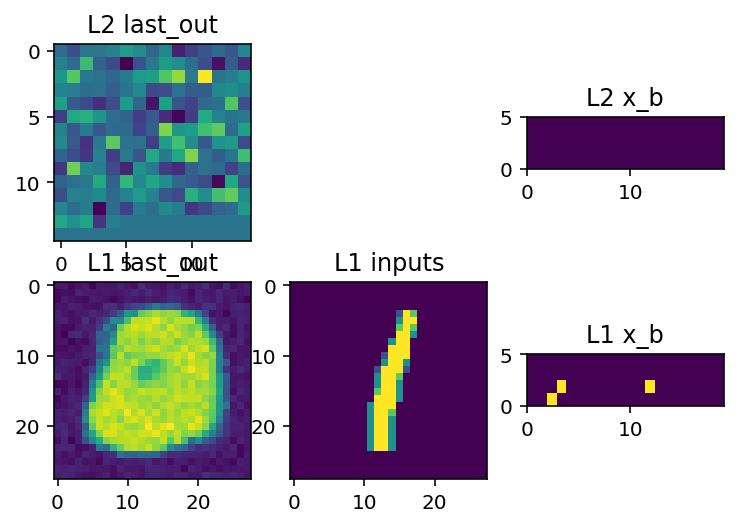

Finished batch 50


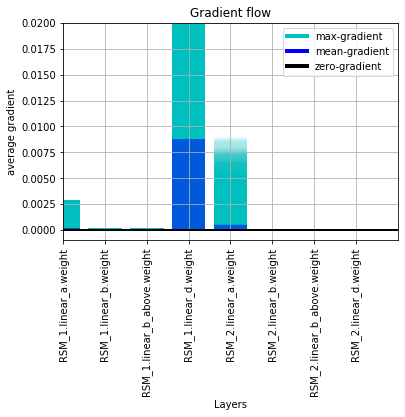

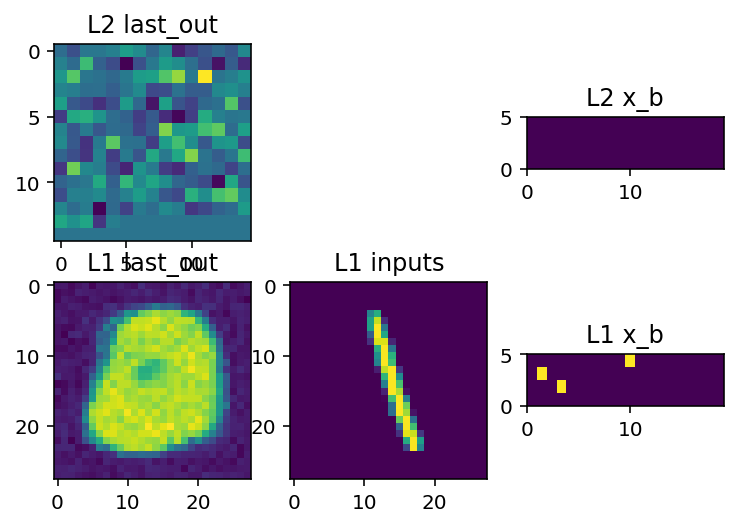

epoch 5 loss 54.18991482257843
Finished batch 0


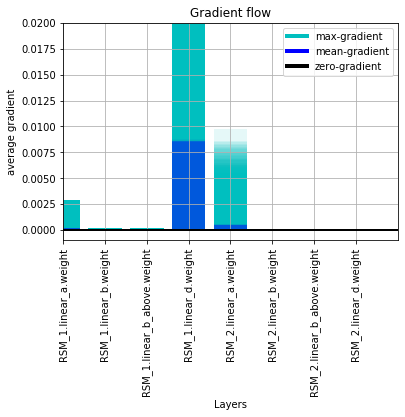

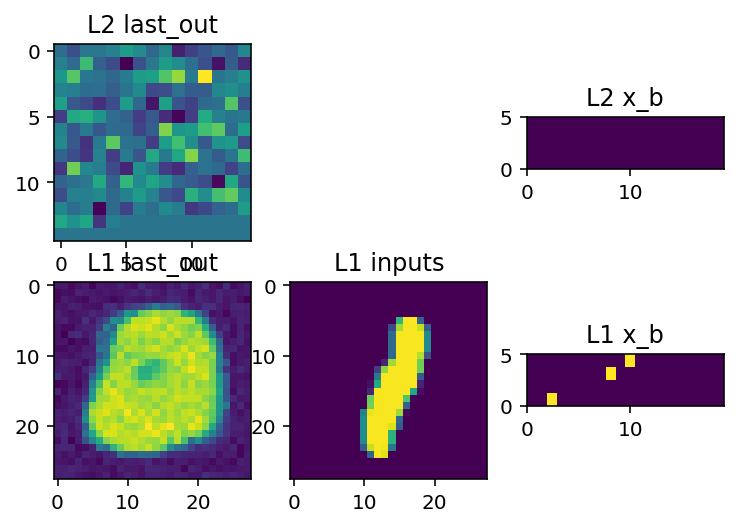

Finished batch 50


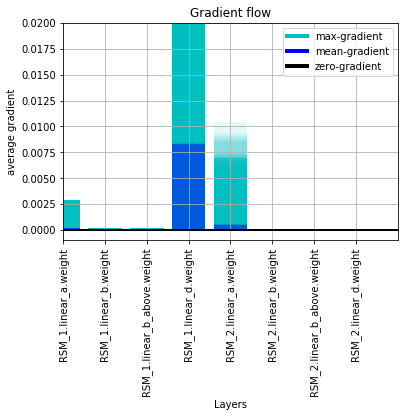

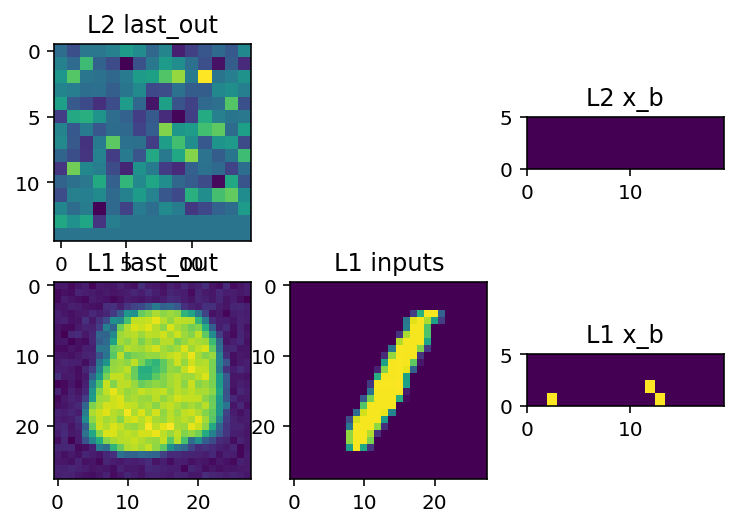

epoch 6 loss 55.58298295736313
Finished batch 0


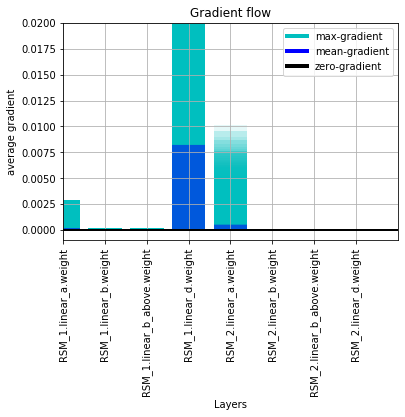

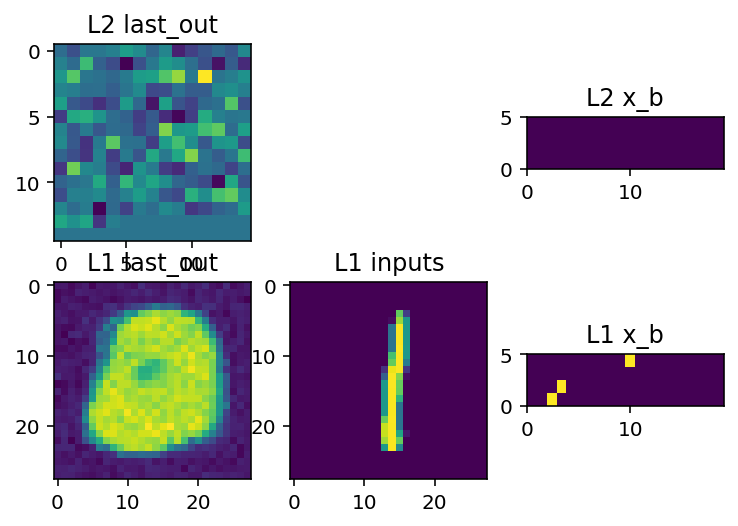

Finished batch 50


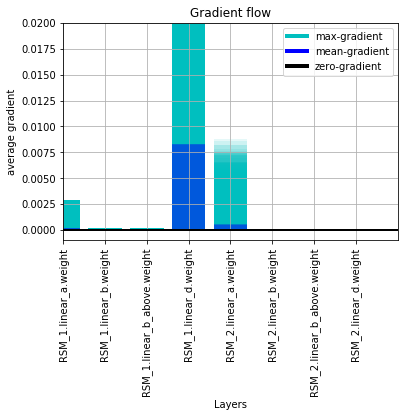

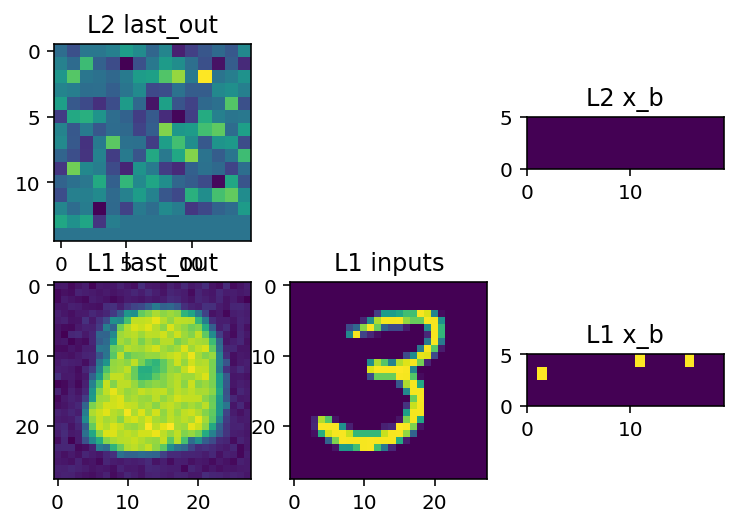

epoch 7 loss 55.46303653717041
Finished batch 0


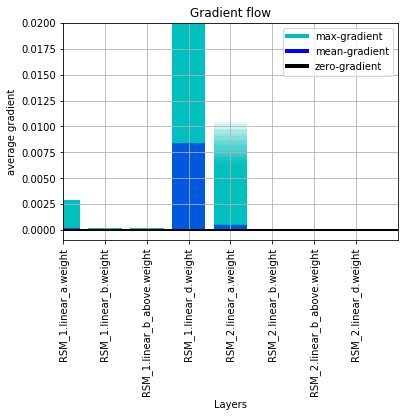

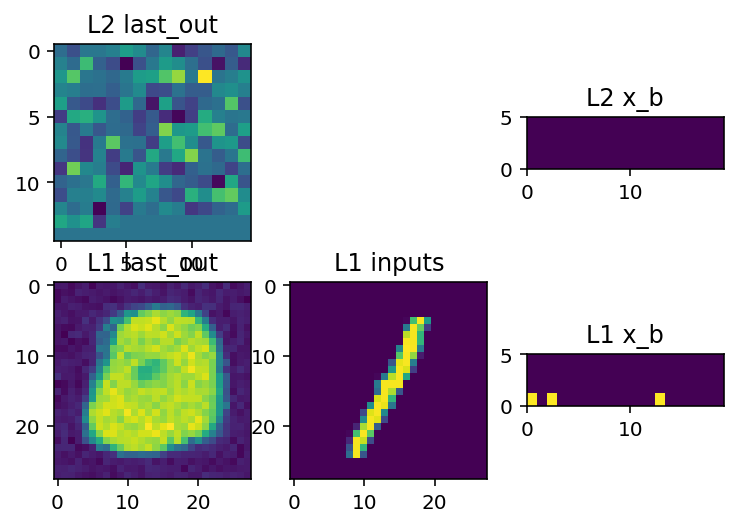

Finished batch 50


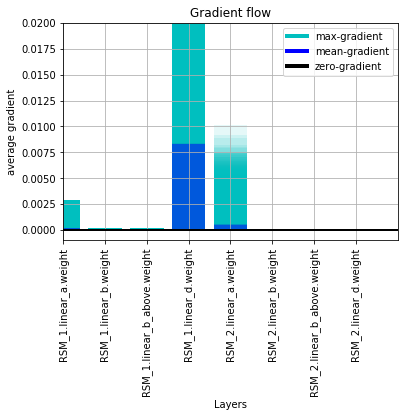

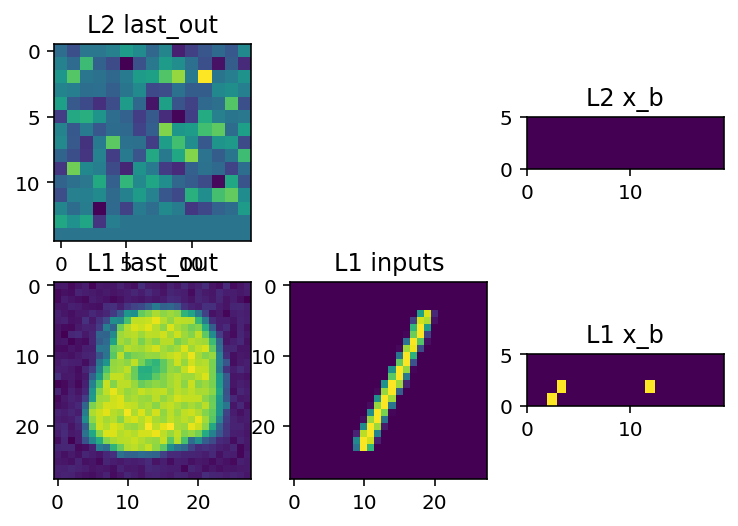

epoch 8 loss 54.96034872531891
Finished batch 0


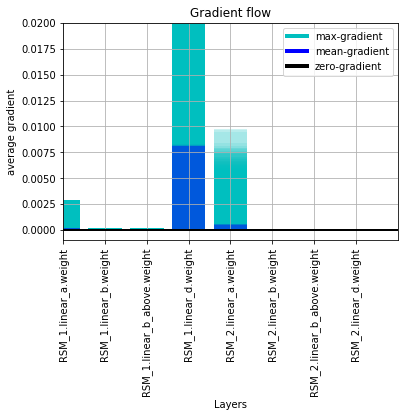

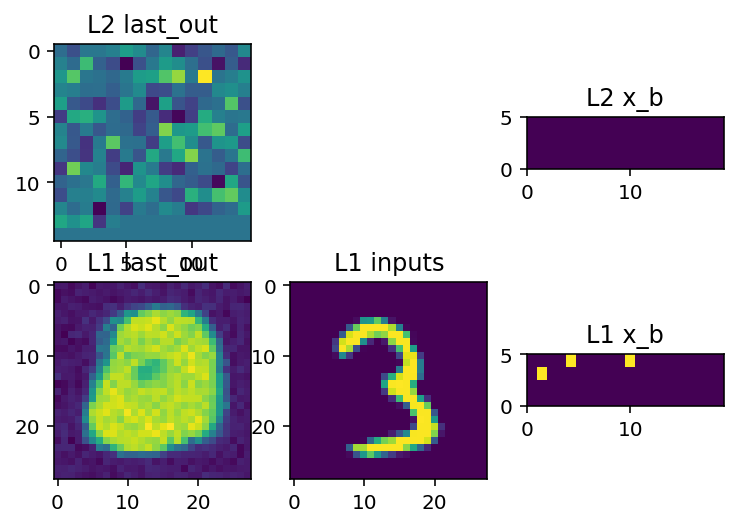

Finished batch 50


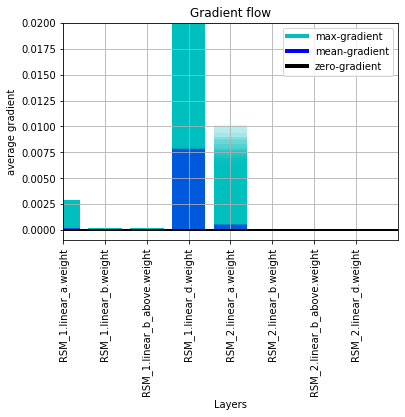

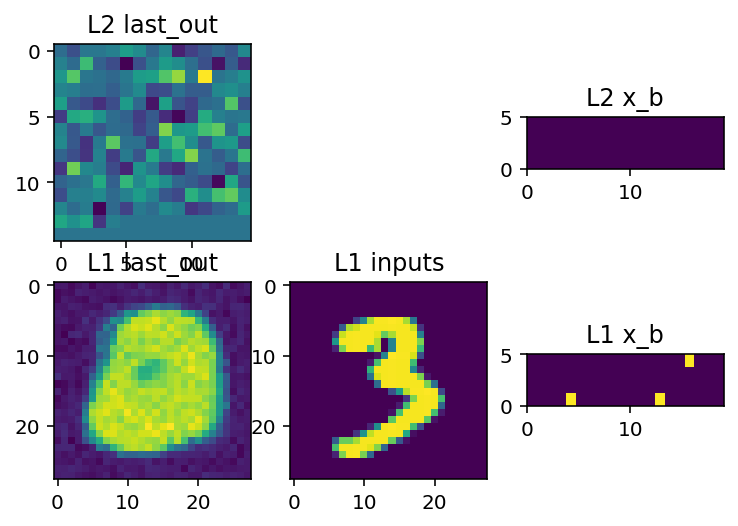

epoch 9 loss 56.71380466222763


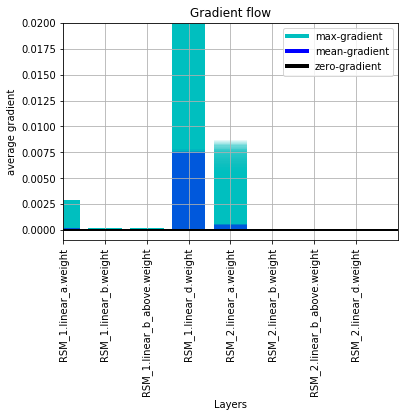

In [273]:
import util
reload(util)

hidden = model.init_hidden(BS)

def _repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(_repackage_hidden(v) for v in h)

for i in range(EPOCHS):
    total_loss = 0.0

    for batch_id, (inputs, target, pred_target, pred_input) in enumerate(loader):
        
#         hidden[1].detach_() 
#         hidden[2].detach_()
        hidden = _repackage_hidden(hidden)
        
        out, hidden = model(inputs, hidden)

        # We need the prior output to calculate loss at layers i>0
        # First layer loss is between last image prediction and actual input image
        loss = criterion(out[0], inputs.detach())
        # Layers > 1 loss is between last output (hidden predictions) and actual hidden
        # ls_loss = criterion(torch.stack(last_output[1:]), x_b[1:].detach())

        loss.backward()
        
        util._plot_grad_flow(model)

        optimizer.step()
        total_loss += loss.item()

        if batch_id % 50 == 0:
            print("Finished batch %d" % batch_id)
            if last_output is not None:
                model._plot_tensors([
                    ('last_out', last_output),
                    ('inputs', [inputs.detach(), None]),
                    ('x_b', hidden[0])
                ])
        
    print('epoch', i, 'loss', total_loss)